# Feature creation for step detection using Machine Learning.

I obtained the overall trajectory of a single spots using Regression in the previous notebook, here I will create new features from these trajectories to create a new algorithm for step detection. <br>

My ML algorithm will have a binary target variable of either 1 or 0, 1 means that the protein takes a step at that frame in the movie. For the algorithm to detect the steps I will generate many features using the position -time (frame) plot that I have, because whether the protein steps depends on the pixel difference between where the step happens and its surrounding; I decided that it will have the following features:<br>
<br>
pos: the position of the protein (y coordinate).<br>
slope: difference between the current position and the previous position.<br>
second_slope: difference between the current position and position two frames ago.<br>
third_slope: difference between the current position and position three frames ago.<br>
fourth_slope: difference between the current position and position four frames ago.<br>
forward_slope: difference between the current position and the next position.<br>
tanhx: tanh of the difference between the previous position and the next position.<br>
tanhx2: tanh of the difference between the two previous position and the second next position.<br>
sinx: sinx of the difference between the previous position and the next position.<br>
<br>
I have 9 columns to feed the algorithm in total.<br>
I wrote here a function that takes the trajectory as the argument and returns a features dataframe to reuse it to generate features for different trajectories.

In [293]:
def create_features(trajectory):
    overall_position = np.sqrt(trajectory[1]**2 + trajectory[0]**2)
    
    pos = []
    slope = []
    second_slope = []
    third_slope = []
    fourth_slope = []
    forward_slope = []
    tanhx = []
    tanhx2 = []
    sinx = []
    target = []
    step_index = 0
    for i in range(4,len(overall_position)-3): #define the range such that the data can be generated for each function as we don't wanna call -2nd frame etc.
        pos = np.append(pos,overall_position[i])
        slope = np.append(slope,overall_position[i-1] - overall_position[i])
        second_slope = np.append(second_slope,overall_position[i-2] - overall_position[i])
        third_slope = np.append(third_slope,overall_position[i-3] - overall_position[i])
        fourth_slope = np.append(fourth_slope,overall_position[i-4] - overall_position[i])
        forward_slope = np.append(forward_slope,overall_position[i+1] - overall_position[i])
        tanhx = np.append(tanhx, np.tanh(overall_position[i+1] - overall_position[i-1]))
        tanhx2 = np.append(tanhx2, np.tanh(overall_position[i+2] - overall_position[i-2]))
        sinx = np.append(sinx, np.sin(overall_position[i+1] - overall_position[i-1]))
   

    features = pd.DataFrame(data = [pos,slope,second_slope,third_slope,fourth_slope,forward_slope,tanhx,tanhx2,sinx]).T
    features.columns = ['pos','slope','second_slope','third_slope','fourth_slope','forward_slope','tanhx','tanhx2','sinx']
    
    return features


Below, I create a target dataframe which is either 0 (no step) or 1.

In [294]:
for i in range(4,len(overall_position)-3): #iterating over the position to create the target flag.
    if i + 1  == step_alerts[step_index]:
        target = np.append(target, 1)
        if step_index < len(step_alerts) - 1:
            step_index = step_index + 1
    else:
        target = np.append(target, 0)
target = pd.DataFrame(target,columns = ['target'])

In [295]:
features = create_features(trajectory)

In [296]:
features.head()

,pos,slope,second_slope,third_slope,fourth_slope,forward_slope,tanhx,tanhx2,sinx
0,142.615650,0.559946,1.076046,1.335530,1.292465,-0.782568,-0.872275,-0.972054,-0.974057
1,141.833082,0.782568,1.342514,1.858614,2.118098,-0.269657,-0.782670,-0.938741,-0.868528
2,141.563425,0.269657,1.052225,1.612171,2.128271,-0.115169,-0.366891,-0.953238,-0.375398
3,141.448256,0.115169,0.384826,1.167394,1.727340,-0.698694,-0.671716,-0.819508,-0.726945
4,140.749562,0.698694,0.813863,1.083520,1.866088,-0.071799,-0.647216,-0.695270,-0.696489


In [297]:
target.head()

,target
0,0.0
1,1.0
2,0.0
3,0.0
4,1.0


There are not many 1s in my target variable, I am going to oversample these columns to account for this imbalance.

In [78]:
from imblearn.over_sampling import RandomOverSampler,SMOTE
from sklearn.model_selection import train_test_split

#os = SMOTE(random_state=0)
os = RandomOverSampler()

columns = features.columns
os_data_X,os_data_y=os.fit_sample(features, target)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['target'])

/Users/enescaglar/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


I am using Logistic Regression to categorize the frame numbers along the trajectory according to whether a step accurs there.

In [88]:
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(os_data_X, os_data_y, test_size=0.2, random_state=0)

lin = LogisticRegression(solver='lbfgs',multi_class='ovr')

lin.fit(X_train,y_train)

y_pred = lin.predict(X_test)

lin.score(X_test,y_test)

/Users/enescaglar/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9666666666666667

Even with very few training data the algorithm is very robust and there is only 1 false positive identification according to the confusion matrix. I will see how the algorithm performs on a new trace now.

In [90]:
confusion_matrix(y_test,y_pred)

array([[16,  1],
       [ 0, 13]])

In [201]:
trajectory = extract_trajectory(2) #the new trace obtained from another image file.

This specific trace needs to be inverted because the forward position depends on the positioning of the molecular tracks (axonemes or microtubules). For now I am only analyzing the forward steps but backstepping also exist and the algorithm has to be trained for them too.

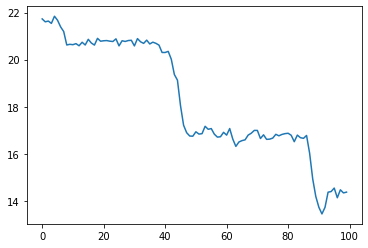

In [211]:
trajectory = pd.DataFrame(32- trajectory) 
plt.plot(np.sqrt(trajectory[1]**2 + trajectory[0]**2))

In [212]:
features = create_features(trajectory)

In [213]:
features.head() #checking the features dataframe to make sure that everything looks good.

,slope,second_slope,third_slope,fourth_slope,forward_slope,tanhx,sinx
0,-0.303059,-0.204475,-0.236775,-0.113405,-0.170042,0.132238,0.132625
1,0.170042,-0.133017,-0.034433,-0.066733,-0.281258,-0.422967,-0.436136
2,0.281258,0.451300,0.148241,0.246825,-0.197517,-0.445262,-0.460692
3,0.197517,0.478775,0.648817,0.345758,-0.571397,-0.646297,-0.695355
4,0.571397,0.768914,1.050172,1.220214,0.027597,-0.495859,-0.517391


In [214]:
step_alerts = lin.predict(features) 

In [215]:
skipped_frames = [0,0,0,0] 
skipped_frames_end = [0,0,0]
step_alerts = np.concatenate((skipped_frames,step_alerts,skipped_frames_end)) #adding the missing frames due to feature generation.

In [225]:
step_alerts

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])

I will plot the trajectory and the flags at the same time to investigate if the algorithm works as expected. Note that this movie has less pixels in total and it looks more noisy for this reason compared to the initial trace.


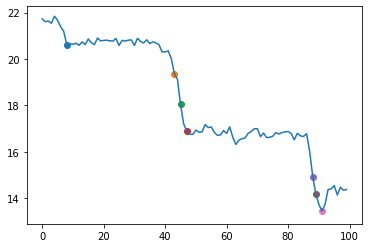

In [226]:
fig, ax = plt.subplots()

plt.plot(np.sqrt(trajectory[1]**2 + trajectory[0]**2))
for index,rows in trajectory.iterrows():
    if step_alerts[index] == 1:
        ax.scatter([index], [np.sqrt(trajectory[1].loc[index]**2 + trajectory[0].loc[index]**2)])



The algorithm works quite efficiently except for finding the backward steps. It gets confused when there is a backstep (around frame # 90). This step finding algorithm was obtained using very few training data. Once the training is done with many more trajectories, the resulting step finding algorithm will be much more efficient not only in finding the forward steps but also the backward steps.